## European Options on SPX

### Getting the data

In [904]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import norm
from math import log, exp

colnames=['Date','Close']
NOTEBOOK_ROOT = "~\Desktop\RBC\Data"

df = pd.read_csv( os.path.join(NOTEBOOK_ROOT, "SPX.csv"), skiprows=1,names = colnames, index_col='Date', parse_dates=True)

In [905]:
df.head()

,Close
Date,
2015-01-01,2058.20
2015-01-05,2020.58
2015-01-06,2002.61
2015-01-07,2025.90
2015-01-08,2062.14


In [757]:
df.describe()

,Close
count,1072.000000
mean,2361.583116
std,303.062073
min,1829.080000
25%,2091.020000
50%,2339.880000
75%,2658.585000
max,2930.750000


In [996]:
days=len(df['2016-01-04' :'2019-01-04'])
print("Number of trading days during the life of the option= {}".format(days))

Number of trading days during the life of the option= 757


## 1. Black-Scholes formula for the pricing of European Calls

$C(S,t)$ is given below, where $S$ is the underlying, $K$ is the strike price, $r$ is the risk-free rate, q is the divend yield, T-t is the time to maturity and $\sigma$ is the (constant)  annualized volatility of the underlying.

\begin{equation}
	C(S, t)=  Se^{-q(T-t)} N(d_1) -  K  e^{-r(T-t)} N( d_2) 
\end{equation}

\begin{equation}
	d_1= \frac{\ln{\left(\frac{S}{K}\right)} + (T-t)\left(r -q + \frac{\sigma^2}{2} \right)}{\sigma \sqrt{T-t}} 
\end{equation}

\begin{equation}
	d_2= \frac{\ln{\left(\frac{S}{K}\right)} + (T-t)\left(r -q - \frac{\sigma^2}{2} \right)}{\sigma \sqrt{T-t}} 
\end{equation}

\begin{equation}
	N(x)=\frac{1}{\sqrt{2\pi}} \int_{-\infty}^{x} e^{-\frac{1}{2}z^2} dz
\end{equation}

**Black-Scholes and d1 functions.**

In [918]:
def d1(S,K,T,r,q,v):
    
    """ 
    Parameters
    ----------
    S -> Spot price
    K -> Strike price
    T-t -> Time to maturirty (assumme t=0)
    r -> Risk-free rate
    q -> Dividend yield
    v -> Volatility
           
    Returns
    --------
    Return the upper (lower) bound for a call (put)
    
    """
    d= (log(S/K)+((r-q)+v*v/2)*T)/(v*sqrt(T))
    
    return d

In [919]:
def BS(Option,S,K,T,r,q,v):
    
    """ 
    Parameters
    ----------
    Option -> Call="c", otherrwise it is a Put
    S -> Spot price
    K -> Strike price
    T-t -> Time to maturirty (assumme t=0)
    r -> Risk-free rate
    q -> Dividend yield
    v -> Volatility
           
    Returns
    --------
    Return the price for a call or put vanilla option
    
    """
    
    d_1=d1(S,K,T,r,q,v)
    d_2=d_1-v*sqrt(T)
    if Option=='c':
        C=S*exp(-q*T)*norm.cdf(d_1)-K*exp(-r*T)*norm.cdf(d_2)
        return C
    else:
        P=K*exp(-r*T)*norm.cdf(-d_2)-S*exp(-q*T)*norm.cdf(-d_1)
        return P

In [1080]:
S=df.loc['2016-01-04', ["Close"]].iloc[0]
K=2500
T=days/252
r=0
q=0
v=0.2

In [1081]:
print( '\033[1m' "S_0={}".format(S))

S_0=2012.66


In [1082]:
Call=BS('c',S,K,T,r,q,v)
print('\033[1m' "Price of a European call={}".format(round(Call,3)))

Price of a European call=124.767


## 2. Greeks

### Delta

In [867]:
def delta(Option, S,K,T,r,q,v):
        
    """ 
    Parameters
    ----------
    Same as BS function
           
    Returns
    --------
    Return the delta for a call or put vanilla option
    
    """    
    d_1=d1(S,K,T,r,q,v)
    N_d1_call=norm.cdf(d_1)*exp(-q*T)
    N_d1_put=-norm.cdf(-d_1)*exp(-q*T)
    
    if Option=='c':
        return N_d1_call
    else:
        return N_d1_put

In [916]:
d=round(delta('c', S,K,T,r,q,v),3)
print('Delta= {}'. format(d))
print( '\033[1m Delta Hedging strategy if a portfolio manager sold call options:' 
      '\n Buy {} shares of the underlying stock now. Adjust the shares over time to maintain a delta-neutral portfolio.'.format(d))

Delta= 0.325
 Delta Hedging strategy if a portfolio manager sold call options:
 Buy 0.325 shares of the underlying stock now. Adjust the shares over time to maintain a delta-neutral portfolio.


### Gamma

In [869]:
def gamma(S,K,T,r,q,v):
        
    """ 
    Parameters
    ----------
    Same as BS function
           
    Returns
    --------
    Return the gamma for a call or put vanilla option
    
    """    
    d_1=d1(S,K,T,r,q,v)
    g=norm.pdf(d_1)*exp(-q*T)/(S*v*sqrt(T))
    
    return g

In [886]:
g=round(gamma(S,K,T,r,q,v),5)
print( 'Gamma= {}'. format(g))

Gamma= 0.00052


### Vega

In [871]:
def vega(S,K,T,r,q,v):  
    """ 
    Parameters
    ----------
    Same as BS function
           
    Returns
    --------
    Return the gamma for a call or put vanilla option
    
    """    
    d_1=d1(S,K,T,r,q,v)
    v=norm.pdf(d_1)*S*sqrt(T)*exp(-q*T)
    
    return v

In [952]:
vg=round(vega(S,K,T,r,q,v),3)
print('Vega= {}'.format(vg))
print( '\033[1m' 'A 1% increase in volatility from 20% to 21% increases the value of the option by approximately {}'.format(vg*0.01))

Vega= 1255.255
A 1% increase in volatility from 20% to 21% increases the value of the option by approximately 12.552550000000002


### Theta

In [937]:
def theta(Option, S,K,T,r,q,v):
    """ 
    Parameters
    ----------
    Same as BS function
           
    Returns
    --------
    Return the theta for a call or put vanilla option
    
    """    
    d_1=d1(S,K,T,r,q,v) 
    d_2 = d_1 - v * sqrt(T)
    
    if Option=='c':
        theta = -S * norm.pdf(d_1) * v *exp(-q*T)/ (2 * sqrt(T)) \
                 +q*S* norm.cdf(d_1)*exp(-q*T) \
                  - r * K * exp(-r*T) * norm.cdf(d_2)
        return theta
    
    else:
        theta = -S * norm.pdf(d_1) * v *exp(-q*T)/ (2 * sqrt(T)) \
                  -q*S* norm.cdf(-d_1)*exp(-q*T) \
                  +r * K * exp(-r*T) * norm.cdf(-d_2)
        return theta

In [972]:
th=round(theta('c', S,K,T,r,q,v),3)
print('Theta= {}'.format(th))
print( '\033[1m' 'Theta is equal to {} per trading day'.format(th/252))

Theta= -41.842
Theta is equal to -0.16603968253968254 per trading day


### Rho

### Option price and greeks over time

In [1001]:
def plot_greeks(Time, Option):    
    
    """
    Plot option price, delta, gamma and vega over time
    
    Parameters
    ----------
    Time
    Option -> Call="c", otherrwise it is a Put
 
    """

    time=np.arange(0.001,3.001,0.001)
    bs= []
    dt=[]
    gm=[]
    vg=[]
    th=[]
    for n in time:
        Call = BS(Option,S,K,n,r,q,v)
        Delta=delta(Option,S,K,n,r,q,v)
        Gamma=gamma(S,K,n,r,q,v)
        Vega=vega(S,K,n,r,q,v)*0.01
        Theta=theta(Option,S,K,n,r,q,v)/252
        bs.append(Call),dt.append(Delta), gm.append(Gamma), vg.append(Vega), th.append(Theta)     
          
    # Create a figure
    fig = plt.figure(figsize=(14,7))
    _ = plt.subplots_adjust(wspace = 0.4, hspace = 0.6 )
    fig.suptitle('Option Price and Greeks over time', fontweight="bold")

    # Createa plot of price over time
    ax = fig.add_subplot(2, 3, 1)
    _ = ax.plot(time , bs, color="blue")
    _ = ax.set_title("Option price", fontweight="bold")
    _ = ax.set_xlabel("Time (years)"); _ = ax.set_ylabel("Option price")
    
    # Createa plot of delta over time
    ax = fig.add_subplot(2, 3, 2)
    _ = ax.plot(time, dt, color="blue")
    _ = ax.set_title("Delta", fontweight="bold")
    _ = ax.set_xlabel("Time (years)"); _ = ax.set_ylabel("Delta")
    
     # Createa plot of gamma over time
    ax = fig.add_subplot(2, 3, 3)
    _ = ax.plot(time , gm, color="blue")
    _ = ax.set_title("Gamma",fontweight="bold")
    _ = ax.set_xlabel("Time (years)"); _ = ax.set_ylabel("Gamma")

    # Createa plot of vega over time
    ax = fig.add_subplot(2, 3, 4)
    _ = ax.plot(time, vg, color="blue")
    _ = ax.set_title("Vega", fontweight="bold")
    _ = ax.set_xlabel("Time (years)"); _ = ax.set_ylabel("Vega")
    
    # Createa plot of theta over time
    ax = fig.add_subplot(2, 3, 5)
    _ = ax.plot(time, th, color="blue")
    _ = ax.set_title("Theta", fontweight="bold")
    _ = ax.set_xlabel("Time (years)"); _ = ax.set_ylabel("Theta")
    
      
    return

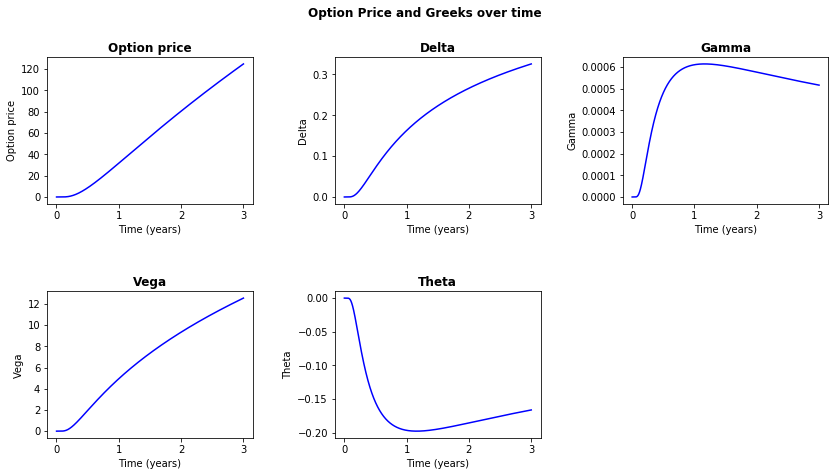

In [1002]:
plot_greeks(3, 'c')

### Realized volatility

We can define realized volatility as:

\begin{equation}
	\sigma=\sqrt{ \frac{252}{n-1} \sum_{i=1}^{n-1} \left[ log \left({\frac{S_{i+1}}{S_i}}\right)\right] ^2}
\end{equation}

I used a percentage change function instead of a log function to calculate the realized volatility.

In [973]:
def rvol(df, ndays, date):
        
    """ 
    Parameters
    ----------
    df -> Dataframe
    Days -> Number of days used to estimate volatility
    date -> String containing the date on which the realized volatility is calculated
   
    Returns
    --------
    Return the realized volatility
    
    """  
    pct= df.loc[:date]['Close'].tail(ndays).pct_change()
    pct=pct.dropna()
    pct=pct**2
    pct=pct.sum()
    vol=sqrt(pct*252/(ndays-1))  
    
    return vol

In [974]:
rv=round(rvol(df, 100, '2016-01-04' ),3)
print("Realized volatility= {}".format(rv))

Realized volatility= 0.198


### Option price using realized volatility

In [975]:
BS('c',S,K,T,r,q,rv)

122.09502605804664

In [976]:
diff=BS('c',S,K,T,r,q,v)-BS('c',S,K,T,r,q,rv)
print('\033[1m' 'Difference in the option price using static volatility and realized volatility={}'.format(diff))

Difference in the option price using static volatility and realized volatility=2.505922221196215


## 3. Daily PnL

We can hedge by taking a stock position that offsets the option’s delta. For instance, **for a short call option, delta hedging  means buying shares**. Because option deltas change as the stock price changes, portfolio managers must continually review and modify their hedging decisions. 

The the daily PnL (delta hedge) is defined as:

\begin{equation}
	PnL_i=\Delta_{i-1}(S_i-S_{i-1})-(C_i-C_{i-1})-rB_{i-1}
\end{equation}

Where $\Delta_i$ denote the option delta on day i, $S_i$ the stock price, $C_i$ the option price, and $B_i=\Delta_{i}S_i-C_i$ is the market value of the portfolio.

The last expression is the overnight gain on shares, less the overnight gain on option, less interest owed (carrying cost of purchasing stocks). In the following function we will assumme r=0.

In [1065]:
def PnL_dh(Option, df, num_cont, date1, date2):

    """ 
    Parameters
    ----------
    Option -> Call="c", otherrwise it is a Put
    df -> Dataframe
    num_cont-> Number of contracts
    date1 -> Start date
    date2 -> End date
           
    Returns
    --------
    Return the realized volatility
    
    """    
    spot= df.loc[date1:date2]['Close'].values.tolist()
    num_days=len(df[date1:date2])
    ttm=list(range(1, num_days+1, 1))[::-1]
    
    dt=[] 
    bs=[]
    for a, b in zip(spot, ttm):
        Call = BS(Option,a,K,b/252,r,q,v)
        Delta=delta(Option,a,K,b/252,r,q,v)
        bs.append(Call), dt.append(Delta)
    df=df.loc[date1:date2].copy()
    df['BS'] = bs
    df['Delta'] = dt
    df['Delta_t-1']=df['Delta'].shift(1).fillna(0) 
    df['Price_chg']=df['Close'].diff().fillna(0) 
    df['BS_chg']=df['BS'].diff().fillna(0)
    df['PnL']= num_cont*(df['Price_chg']*df['Delta_t-1']- df['BS_chg'])
    
    return df

Accumulated PnL= 88.24369666000693


Text(0.5, 0, 'Date')

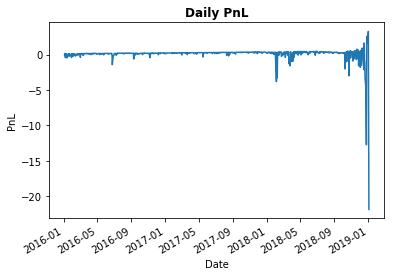

In [1066]:
dh=PnL_dh('c',df,1, '2016-01-04', '2019-01-04')
PnL=dh['PnL'].sum()
print('Accumulated PnL= {}'.format(PnL))
dh['PnL'].plot()
plt.title('Daily PnL', fontweight="bold" )
plt.ylabel("PnL")
plt.xlabel("Date")

In [1084]:
dh.head(10)

,Close,BS,Delta,Delta_t-1,Price_chg,BS_chg,PnL
Date,,,,,,,
2016-01-04,2012.66,124.766952,0.325558,0.000000,0.00,0.000000,0.000000
2016-01-05,2016.71,125.922926,0.327461,0.325558,4.05,1.155974,0.162538
2016-01-06,1990.26,117.280357,0.313626,0.327461,-26.45,-8.642569,-0.018762
2016-01-07,1943.09,102.904701,0.289282,0.313626,-47.17,-14.375656,-0.418086
2016-01-08,1922.03,96.776858,0.278400,0.289282,-21.06,-6.127843,0.035554
2016-01-11,1923.67,97.085636,0.279021,0.278400,1.64,0.308778,0.147798
2016-01-12,1938.68,101.179166,0.286424,0.279021,15.01,4.093530,0.094570
2016-01-13,1890.28,87.766789,0.261821,0.286424,-48.40,-13.412377,-0.450560
2016-01-14,1921.84,96.131318,0.277469,0.261821,31.56,8.364529,-0.101466


In [1068]:
dh.describe()

,Close,BS,Delta,Delta_t-1,Price_chg,BS_chg,PnL
count,757.000000,757.000000,757.000000,757.000000,757.000000,757.000000,757.000000
mean,2429.801691,217.373272,0.546546,0.545430,0.685971,-0.119187,0.116570
std,285.545909,91.245763,0.195693,0.196398,20.369905,13.028234,1.113923
min,1829.080000,1.492446,0.044058,0.000000,-113.190000,-86.330112,-21.864421
25%,2169.180000,142.435137,0.377828,0.377523,-5.910000,-3.087223,0.160475
50%,2435.610000,203.454194,0.505575,0.505038,1.000000,0.188072,0.239808
75%,2689.860000,282.513660,0.709420,0.708921,9.660000,4.450482,0.326273
max,2930.750000,444.859324,0.970556,0.970556,116.600000,55.183614,3.292995


### Daily PnL using Gamma and Theta

Clearly, delta, gamma, and theta all play a role in determining the profit on a delta-hedged position. Using Ito's lemma we can get the Black-Scholes equation for an European calll by solving the folowing PDE subject to boundary conditions:


\begin{equation}
	 \frac{\partial C}{\partial t} + \frac{1}{2}\sigma^2 s^2\frac{\partial^2 C}{\partial S^2}+rS\frac{\partial C}{\partial S}-rC=0
\end{equation}

We can apply this concept in discrete time to get PnL over a period of lenght h.

\begin{equation}
	PnL=\Delta_{t}(S_{t+h}-S_{t})-(C_{t+h}-C_{t})-rh(\Delta_t S_t -C_t)
\end{equation}

\begin{equation}
	PnL=\Delta_{t}(S_{t+h}-S_{t})-[\Delta_t(S_{t+h}-S_t)+\frac{1}{2}(S_{t+h}-S_t)^2 \Gamma_t + \theta_t h]-rh(\Delta_t S_t -C_t)
\end{equation}

\begin{equation}
	PnL=-h \Bigg ( \frac{1}{2} \sigma^2 S_t^2 \Gamma_t^2 + \theta_t +r \Big[ \Delta_t S_t -C_t \Big ]   \Bigg )
\end{equation}

In [1104]:
def profit(Option, df, num_cont, date1, date2, h, v):

    """ 
    Parameters
    ----------
    Option -> Call="c", otherrwise it is a Put
    df -> Dataframe
    num_cont-> Number of contracts
    date1 -> Start date
    date2 -> End date
    h-> Period of lenght h (1/252)
           
    Returns
    --------
    Return the realized volatility
    
    """    
    spot= df.loc[date1:date2]['Close'].values.tolist()
    num_days=len(df[date1:date2])
    ttm=list(range(1, num_days+1, 1))[::-1]
    
    gm=[] 
    th=[]
    for a, b in zip(spot, ttm):
        Gamma = gamma(a,K,b/252,r,q,v)
        Theta=theta(Option,a,K,b/252,r,q,v)
        gm.append(Gamma), th.append(Theta)
    df=df.loc[date1:date2].copy()
    df['Gamma'] = gm
    df['Theta'] = th
    df['PnL']= -num_cont*h*(0.5* v**2 * df['Close']**2 * df['Gamma'] + df['Theta'])
    
    return df

Accumulated PnL= -2.3741150139285885e-14


Text(0.5, 0, 'Date')

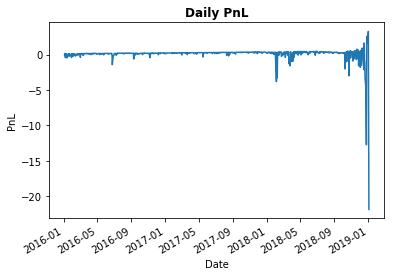

In [1106]:
h=1/252
pf=profit('c',df,1, '2016-01-04', '2019-01-04', h, v)
PnL=pf['PnL'].sum()
print('Accumulated PnL= {}'.format(PnL))
dh['PnL'].plot()
plt.title('Daily PnL', fontweight="bold" )
plt.ylabel("PnL")
plt.xlabel("Date")

## 4. Explaining results